In [ ]:
import torch
from cfm.datasets import EpochShufflePairDataset, sample_toy
from cfm import SimpleFlowModel, Trainer, FlowModelPipeline
import matplotlib.pyplot as plt

### Train the model

### I-CFM: moon->6gaussians

Sampling moons with noise=0.05


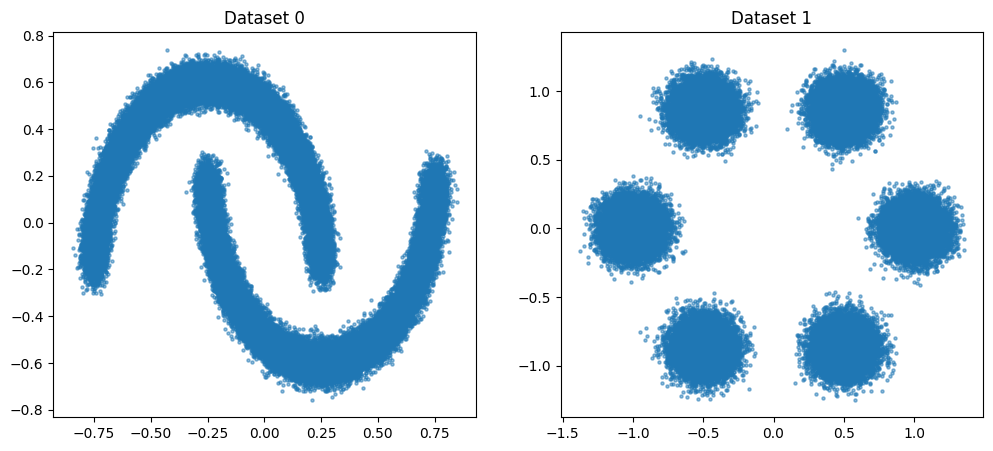

In [3]:
x_source = sample_toy('moons', n_samples=100000, noise=0.05)
x_target = sample_toy('6gaussians', n_samples=100000, noise=0.1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_source[:, 0], x_source[:, 1], s=5, alpha=0.5)
plt.title('Dataset 0')
plt.subplot(1, 2, 2)
plt.scatter(x_target[:, 0], x_target[:, 1], s=5, alpha=0.5)
plt.title('Dataset 1')
plt.show()

In [4]:
dataset = EpochShufflePairDataset(x_source, x_target)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=False)

flow_model = SimpleFlowModel(input_dim=2, time_dim=8, hidden_dim=128)

optimizer = torch.optim.Adam(flow_model.parameters(), lr=1e-3)

trainer = Trainer(flow_model, dataloader, n_epochs=500, sigma=0.005, coupling=None, optimizer=optimizer)
trainer.train()

torch.save(flow_model.state_dict(), 'checkpoints/icfm_moon_6gaussians.pth')

Training with source samples from the dataset.


Epoch [500/500], Loss: 0.2740: 100%|██████████| 500/500 [05:28<00:00,  1.52it/s]


In [2]:
flow_model = SimpleFlowModel(input_dim=2, time_dim=8, hidden_dim=128)
flow_model.load_state_dict(torch.load('checkpoints/icfm_moon_6gaussians.pth'))

pipeline_ot = FlowModelPipeline(flow_model, device='cpu')

# source dataset
seeds = sample_toy('moons', n_samples=10000, noise=0.05)
# targets = sample_toy('circles', n_samples=1000, noise=0.1)

pipeline_ot.generate_animation(
    seeds, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), n_steps=100,
    title = 'I-CFM: moon->6gaussians',
    save_path='assets/icfm_moon_6gaussians.mp4'
)

Sampling moons with noise=0.05


### OT-CFM: moon->6gaussians

In [ ]:
from cfm import ot_coupling_minibatch

dataset = EpochShufflePairDataset(x_source, x_target)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)

flow_model_ot = SimpleFlowModel(input_dim=2, time_dim=8, hidden_dim=128)

optimizer = torch.optim.Adam(flow_model_ot.parameters(), lr=1e-3)

trainer = Trainer(flow_model_ot, dataloader, n_epochs=500, sigma=0.005, coupling=ot_coupling_minibatch, optimizer=optimizer)
trainer.train()

torch.save(flow_model_ot.state_dict(), 'checkpoints/otcfm_moon_6gaussians.pth')


Training with source samples from the dataset.


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [500/500], Loss: 0.0020: 100%|██████████| 500/500 [44:12<00:00,  5.30s/it]


In [13]:
flow_model_ot = SimpleFlowModel(input_dim=2, time_dim=8, hidden_dim=128)
flow_model_ot.load_state_dict(torch.load('checkpoints/otcfm_moon_6gaussians.pth'))

pipeline_ot = FlowModelPipeline(flow_model_ot, device='cpu')

# source dataset
seeds = sample_toy('moons', n_samples=10000, noise=0.05)
# targets = sample_toy('circles', n_samples=1000, noise=0.1)

pipeline_ot.generate_animation(
    seeds, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), n_steps=100,
    title = 'OT-CFM: moon->6gaussians',
    save_path='assets/otcfm_moon_6gaussians.mp4'
    color='red'
)

Sampling moons with noise=0.05


In [3]:
from moviepy import VideoFileClip, clips_array

clip1 = VideoFileClip("assets/icfm_moon_6gaussians.mp4")
clip2 = VideoFileClip("assets/otcfm_moon_6gaussians.mp4")

h = min(clip1.h, clip2.h)

clip1 = clip1.resized(height=h)
clip2 = clip2.resized(height=h)

final = clips_array([[clip1, clip2]])
final.write_videofile("assets/comparison.mp4")

MoviePy - Building video assets/comparison.mp4.
MoviePy - Writing video assets/comparison.mp4



MoviePy - Done !
MoviePy - video ready assets/comparison.mp4


In [4]:
from cfm.utils import mp4_to_frames, crop_frames
mp4_to_frames("assets/comparison.mp4", "assets/comparison_frames", fps=2)